 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn

from src.da_models.adda import ADDAST
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import (
    load_spatial,
    load_sc,
    get_selected_dir,
    get_model_rel_path,
)
from src.utils.evaluation import format_iters

script_start_time = datetime.datetime.now(datetime.timezone.utc)


/tmp/ipykernel_849062/1874826389.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
TORCH_MANUAL_SEED = 72
CUDA_DEVICE = 3


In [3]:
# Data path and parameters
DATA_DIR = "data"
TRAIN_USING_ALL_ST_SAMPLES = False
N_MARKERS = 20
ALL_GENES = False

# Pseudo-spot parameters
N_SPOTS = 20000
N_MIX = 8

# ST spot parameters
ST_SPLIT = False

# Scaler parameter
SCALER_NAME = "celldart"

MODEL_NAME = "ADDA"
MODEL_VERSION = "celldart"

adda_kwargs = {
    "emb_dim": 64,
    "bn_momentum": 0.99,
}


BATCH_SIZE = 1024
NUM_WORKERS = 16

# Pretraining parameters
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS



In [4]:
## Adversarial Hyperparameters

EPOCHS = 200
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS
ENC_LR = 0.0002
ADAM_BETA_1 = 0.5
ALPHA = 2
DIS_LOOP_FACTOR = 5


In [5]:
if CUDA_DEVICE:
    device = torch.device(f"cuda:{CUDA_DEVICE}" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)

In [6]:
if TORCH_MANUAL_SEED or TORCH_MANUAL_SEED == 0:
    torch_seed = TORCH_MANUAL_SEED
    torch_seed_path = str(TORCH_MANUAL_SEED)
else:
    torch_seed = int(script_start_time.timestamp())
    torch_seed_path = script_start_time.strftime("%Y-%m-%d_%Hh%Mm%Ss")

torch.manual_seed(torch_seed)
np.random.seed(torch_seed-1)

In [7]:
model_folder = get_model_rel_path(
    MODEL_NAME,
    MODEL_VERSION,
    scaler_name=SCALER_NAME,
    n_markers=N_MARKERS,
    all_genes=ALL_GENES,
    n_mix=N_MIX,
    n_spots=N_SPOTS,
    st_split=ST_SPLIT,
    torch_seed_path=torch_seed_path,
)
model_folder = os.path.join("model", model_folder)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)



 # Data load

In [8]:
# Load spatial data
mat_sp_d, mat_sp_train, st_sample_id_l = load_spatial(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    train_using_all_st_samples=TRAIN_USING_ALL_ST_SAMPLES,
    st_split=ST_SPLIT,
)

# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    n_mix=N_MIX,
    n_spots=N_SPOTS,
)



 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [9]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_d["train"], lab_mix_d["train"])
source_val_set = SpotDataset(sc_mix_d["val"], lab_mix_d["val"])
source_test_set = SpotDataset(sc_mix_d["test"], lab_mix_d["test"])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_train_set_d = {}
dataloader_target_train_d = {}
if ST_SPLIT:
    target_val_set_d = {}
    target_test_set_d = {}

    dataloader_target_val_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        target_val_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["val"])
        target_test_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["test"])

        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_val_d[sample_id] = torch.utils.data.DataLoader(
            target_val_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

else:
    target_test_set_d = {}
    dataloader_target_test_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_test_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["test"])
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["train"])
        )
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        
if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
   

 ## Define Model

In [10]:
model = ADDAST(
    inp_dim=sc_mix_d["train"].shape[1],
    ncls_source=lab_mix_d["train"].shape[1],
    is_adda=True,
    **adda_kwargs
)
model.apply(initialize_weights)
model.to(device)


ADDAST(
  (source_encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
    )
  )
  (clf): AddaPredictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
    )
  )
)

 ## Pretrain

In [11]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [12]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [13]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def run_pretrain_epoch(model, dataloader, optimizer=None, scheduler=None, inner=None):
    loss_running = []
    mean_weights = []

    is_training = model.training and optimizer

    for _, batch in enumerate(dataloader):
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
        if inner:
            inner.update(1)
    return loss_running, mean_weights


def compute_acc(dataloader, model):

    model.eval()
    with torch.no_grad():
        loss_running, mean_weights = run_pretrain_epoch(model, dataloader)

    return np.average(loss_running, weights=mean_weights)


In [14]:
model.pretraining()


In [15]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

with DupStdout().dup_to_file(os.path.join(pretrain_folder, "log.txt"), "w") as f_log:
    # Train
    print("Start pretrain...")
    outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
    inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)
    
    print(" Epoch | Train Loss | Val Loss   ")
    print("---------------------------------")
    checkpoint = {
        "epoch": -1,
        "model": model,
        "optimizer": pre_optimizer,
        "scheduler": pre_scheduler,
        # 'scaler': scaler
    }
    for epoch in range(INITIAL_TRAIN_EPOCHS):
        inner.refresh()  # force print final state
        inner.reset()  # reuse bar

        checkpoint["epoch"] = epoch

        # Train mode
        model.train()

        loss_running, mean_weights = run_pretrain_epoch(
            model, dataloader_source_train, optimizer=pre_optimizer, scheduler=pre_scheduler, inner=inner
        )

        loss_history.append(np.average(loss_running, weights=mean_weights))
        loss_history_running.append(loss_running)

        # Evaluate mode
        model.eval()
        with torch.no_grad():
            curr_loss_val = compute_acc(dataloader_source_val, model)
            loss_history_val.append(curr_loss_val)

        # Print the results
        outer.update(1)
        print(
            f" {epoch:5d}",
            f"| {loss_history[-1]:<10.8f}",
            f"| {curr_loss_val:<10.8f}",
            end=" ",
        )
        # Save the best weights
        if curr_loss_val < best_loss_val:
            best_loss_val = curr_loss_val
            torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
            early_stop_count = 0

            print("<-- new best val loss")
        else:
            print("")

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
            torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

        # check to see if validation loss has plateau'd
        if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
            print(
                f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
            )
            torch.save(
                checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth")
            )
            break

        early_stop_count += 1

    # Save final model
    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch | Train Loss | Val Loss   
---------------------------------
     0 | 2.35322541 | 1.50237910 <-- new best val loss
     1 | 1.90326145 | 1.26403427 <-- new best val loss
     2 | 1.64389552 | 1.12803777 <-- new best val loss
     3 | 1.46625590 | 1.03857851 <-- new best val loss
     4 | 1.32668267 | 0.97118576 <-- new best val loss
     5 | 1.21787508 | 0.91359733 <-- new best val loss
     6 | 1.13107527 | 0.87926428 <-- new best val loss
     7 | 1.06377469 | 0.83996338 <-- new best val loss
     8 | 1.00923407 | 0.81346722 <-- new best val loss
     9 | 0.96067399 | 0.79419126 <-- new best val loss
    10 | 0.92279427 | 0.76665239 <-- new best val loss
    11 | 0.88615338 | 0.74324930 <-- new best val loss
    12 | 0.85657099 | 0.73212051 <-- new best val loss
    13 | 0.82644506 | 0.72037735 <-- new best val loss
    14 | 0.80303562 | 0.70189192 <-- new best val loss
    15 | 0.78007066 | 0.68872086 <-- new best val loss
    16 | 0.75865914 | 0.68049033 <-- new best val lo

 ## Adversarial Adaptation

In [16]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [17]:
# def cycle_iter(iter):
#     while True:
#         yield from iter


# def iter_skip(iter, n=1):
#     for i in range(len(iter) * n):
#         if (i % n) == n - 1:
#             yield next(iter)
#         else:
#             yield None, None


In [18]:
criterion_dis = nn.BCEWithLogitsLoss()


In [19]:
def discrim_loss_accu(x, domain, model):
    x = x.to(device)

    if domain == "source":
        y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.source_encoder(x)  # .view(x.shape[0], -1)
    elif domain == "target":
        y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.target_encoder(x)  # .view(x.shape[0], -1)
    else:
        raise (
            ValueError,
            f"invalid domain {domain} given, must be 'source' or 'target'",
        )

    y_pred = model.dis(emb)

    loss = criterion_dis(y_pred, y_dis)
    accu = (
        (torch.round(torch.sigmoid(y_pred)).to(torch.long) == y_dis)
        .to(torch.float32)
        .mean()
        .cpu()
    )

    return loss, accu


# def discrim_loss_accu(x_source, x_target, model):
#     # x = x.to(device)

#     x_source, x_target = x_source.to(device), x_target.to(device)

#     # if domain == 'source':
#     #     y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.source_encoder(x) #.view(x.shape[0], -1)
#     # elif domain == 'target':
#     #     y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.target_encoder(x) #.view(x.shape[0], -1)
#     # else:
#     #     raise(ValueError, f"invalid domain {domain} given, must be 'source' or 'target'")

#     y_dis = torch.cat(
#         [
#             torch.zeros(x_source.shape[0], device=device, dtype=x_source.dtype).view(
#                 -1, 1
#             ),
#             torch.ones(x_target.shape[0], device=device, dtype=x_target.dtype).view(
#                 -1, 1
#             ),
#         ]
#     )
#     x = torch.cat([x_source, x_target])
#     emb = model.source_encoder(x)  # .view(x.shape[0], -1)
#     y_pred = model.dis(emb)

#     loss = criterion_dis(y_pred, y_dis)
#     accu = torch.mean(
#         (torch.round(y_pred).to(torch.long) == y_dis).to(torch.float32)
#     ).cpu()

#     return loss, accu


def compute_acc_dis(dataloader_source, dataloader_target, model):
    results_history = {
        "dis": {
            "source": {},
            "target": {},
        }
    }

    model.eval()
    model.dis.eval()
    model.target_encoder.eval()
    model.source_encoder.eval()
    with torch.no_grad():
        loss_running, accu_running, mean_weights = run_adv_epoch_dis(
            model, dataloader_source, "source"
        )
        results_history["dis"]["source"]["loss"] = np.average(
            loss_running, weights=mean_weights
        )
        results_history["dis"]["source"]["accu"] = np.average(
            accu_running, weights=mean_weights
        )

        loss_running, accu_running, mean_weights = run_adv_epoch_dis(
            model, dataloader_target, "target"
        )
        results_history["dis"]["target"]["loss"] = np.average(
            loss_running, weights=mean_weights
        )
        results_history["dis"]["target"]["accu"] = np.average(
            accu_running, weights=mean_weights
        )
    return results_history


def run_adv_epoch_dis(model, dataloader, domain):
    loss_running = []
    accu_running = []
    mean_weights = []
    for _, (X, _) in enumerate(dataloader):
        loss, accu = discrim_loss_accu(X, domain, model)
        loss_running.append(loss.item())
        accu_running.append(accu)
        mean_weights.append(len(X))
    return loss_running, accu_running, mean_weights


def encoder_loss(x_target, model):
    x_target = x_target.to(device)

    # flip label
    y_dis = torch.zeros(x_target.shape[0], device=device, dtype=x_target.dtype).view(
        -1, 1
    )

    emb_target = model.target_encoder(x_target)  # .view(x_target.shape[0], -1)
    y_pred = model.dis(emb_target)
    loss = criterion_dis(y_pred, y_dis)
    accu = (
        (torch.round(torch.sigmoid(y_pred)).to(torch.long) == y_dis)
        .to(torch.float32)
        .mean()
        .cpu()
    )

    return loss, accu


In [20]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
    dataloader_target_train_dis,
):
    model.to(device)
    model.advtraining()

    target_optimizer = torch.optim.Adam(
        model.target_encoder.parameters(),
        lr=ENC_LR,
        betas=(ADAM_BETA_1, 0.999),
        eps=1e-07,
    )
    dis_optimizer = torch.optim.Adam(
        model.dis.parameters(), lr=ALPHA * ENC_LR, betas=(ADAM_BETA_1, 0.999), eps=1e-07
    )

    # iters = -(max_len_dataloader // -(1 + DIS_LOOP_FACTOR))  # ceiling divide

    dataloader_lengths = [
        len(dataloader_source_train),
        len(dataloader_target_train),
        len(dataloader_target_train_dis) * DIS_LOOP_FACTOR,
    ]
    max_len_dataloader = np.amax(dataloader_lengths)
    longest = np.argmax(dataloader_lengths)

    # dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )
    # target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )

    # Initialize lists to store loss and accuracy values
    # loss_history = []
    # accu_history = []
    # loss_history_val = []
    # accu_history_val = []
    # loss_history_running = []

    # loss_history_gen = []
    # loss_history_gen_running = []
    # mean_weights_gen = []

    results_template = {
        "dis": {
            "source": {"loss": [], "accu": [], "weights": []},
            "target": {"loss": [], "accu": [], "weights": []},
        },
        "gen": {
            "target": {"loss": [], "accu": [], "weights": []},
        },
    }
    results_history = deepcopy(results_template)
    results_history_val = deepcopy(results_template)
    results_history_running = deepcopy(results_template)

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        # Train
        print("Start adversarial training...")
        outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
        inner1 = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)

        print(" Epoch ||| Generator       ||| Discriminator ")
        print(
            "       ||| Train           ||| Train                             || Validation    "
        )
        print(
            "       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  "
        )
        print(
            "       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target "
        )
        print(
            "------------------------------------------------------------------------------------------------------"
        )
        checkpoint = {
            "epoch": -1,
            "model": model,
            "dis_optimizer": dis_optimizer,
            "target_optimizer": target_optimizer,
            # "dis_scheduler": dis_scheduler,
            # "target_scheduler": target_scheduler,
        }
        for epoch in range(EPOCHS):
            inner1.refresh()  # force print final state
            inner1.reset()  # reuse bar

            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            model.target_encoder.train()
            model.source_encoder.eval()
            model.dis.train()

            results_running = deepcopy(results_template)

            s_train_iter = iter(dataloader_source_train)
            t_train_iter = iter(dataloader_target_train)
            t_train_dis_iter = iter(dataloader_target_train_dis)
            for i in range(max_len_dataloader):
                try:
                    x_source, _ = next(s_train_iter)
                except StopIteration:
                    s_train_iter = iter(dataloader_source_train)
                    x_source, _ = next(s_train_iter)
                try:
                    x_target, _ = next(t_train_iter)
                except StopIteration:
                    t_train_iter = iter(dataloader_target_train)
                    x_target, _ = next(t_train_iter)

                train_encoder_step = (i % DIS_LOOP_FACTOR) == DIS_LOOP_FACTOR - 1

                model.train_discriminator()
                # model.target_encoder.train()
                # model.source_encoder.train()
                # model.dis.train()

                set_requires_grad(model.target_encoder, False)
                set_requires_grad(model.source_encoder, False)
                set_requires_grad(model.dis, True)

                # lr_history_running.append(scheduler.get_last_lr())
                dis_optimizer.zero_grad()

                loss, accu = discrim_loss_accu(x_source, "source", model)
                results_running["dis"]["source"]["loss"].append(loss.item())
                results_running["dis"]["source"]["accu"].append(accu)
                results_running["dis"]["source"]["weights"].append(len(x_source))

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                dis_optimizer.step()

                dis_optimizer.zero_grad()

                loss, accu = discrim_loss_accu(x_target, "target", model)
                results_running["dis"]["target"]["loss"].append(loss.item())
                results_running["dis"]["target"]["accu"].append(accu)
                results_running["dis"]["target"]["weights"].append(len(x_target))

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                dis_optimizer.step()
                # dis_scheduler.step()

                # print(i % DIS_LOOP_FACTOR)
                if train_encoder_step:
                    try:
                        x_target_enc, _ = next(t_train_dis_iter)
                    except StopIteration:
                        t_train_dis_iter = iter(dataloader_target_train_dis)
                        x_target_enc, _ = next(t_train_dis_iter)
                    model.train_target_encoder()
                    # model.target_encoder.train()
                    # model.source_encoder.train()
                    # model.dis.train()

                    set_requires_grad(model.target_encoder, True)
                    set_requires_grad(model.source_encoder, False)
                    set_requires_grad(model.dis, False)

                    target_optimizer.zero_grad()

                    loss, accu = encoder_loss(x_target_enc, model)

                    results_running["gen"]["target"]["loss"].append(loss.item())
                    results_running["gen"]["target"]["accu"].append(accu)
                    results_running["gen"]["target"]["weights"].append(
                        len(x_target_enc)
                    )

                    loss.backward()
                    target_optimizer.step()
                # target_scheduler.step()

                inner1.update(1)
            for module_k in results_running:
                for domain_k in results_running[module_k]:
                    for metric_k in results_running[module_k][domain_k]:
                        results_history[module_k][domain_k][metric_k].append(
                            np.average(
                                results_running[module_k][domain_k][metric_k],
                                weights=results_running[module_k][domain_k]["weights"],
                            )
                        )

            for module_k in results_running:
                for domain_k in results_running[module_k]:
                    for metric_k in results_running[module_k][domain_k]:
                        results_history_running[module_k][domain_k][metric_k].append(
                            results_running[module_k][domain_k][metric_k],
                        )

            model.eval()
            model.dis.eval()
            model.target_encoder.eval()
            model.source_encoder.eval()

            set_requires_grad(model, True)
            set_requires_grad(model.target_encoder, True)
            set_requires_grad(model.source_encoder, True)
            set_requires_grad(model.dis, True)

            # del batch_cycler
            with torch.no_grad():
                results_val = compute_acc_dis(
                    dataloader_source_val, dataloader_target_train, model
                )
            for module_k in results_val:
                for domain_k in results_val[module_k]:
                    for metric_k in results_val[module_k][domain_k]:
                        results_history_val[module_k][domain_k][metric_k].append(
                            results_val[module_k][domain_k][metric_k]
                        )
            # Print the results
            outer.update(1)
            print(
                f" {epoch:5d}",
                f"||| {results_history['gen']['target']['loss'][-1]:6.4f}",
                f"- {results_history['gen']['target']['accu'][-1]:6.4f}",
                f"||| {results_history['dis']['source']['loss'][-1]:6.4f}",
                f"- {results_history['dis']['target']['loss'][-1]:6.4f}",
                f"| {results_history['dis']['source']['accu'][-1]:6.4f}",
                f"- {results_history['dis']['target']['accu'][-1]:6.4f}",
                f"|| {results_history_val['dis']['source']['loss'][-1]:6.4f}",
                f"- {results_history_val['dis']['target']['loss'][-1]:6.4f}",
                f"| {results_history_val['dis']['source']['accu'][-1]:6.4f}",
                f"- {results_history_val['dis']['target']['accu'][-1]:6.4f}",
                end=" ",
            )

            # # Save the best weights
            # if diff_from_rand < best_loss_val:
            #     best_loss_val = diff_from_rand
            #     torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
            #     early_stop_count = 0

            #     print("<-- new best difference from random loss")
            # else:
            #     print("")

            print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= EPOCHS - 1:
                torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
                print(
                    f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth")
                )
                break

            early_stop_count += 1

    # Save final model
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))

    return results_history, results_history_running, results_history_val


In [21]:
def plot_results(
    results_history, results_history_running, results_history_val, save_folder
):

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(9, 12), layout="constrained")

    # loss
    axs[0].plot(
        *format_iters(results_history_running["dis"]["source"]["loss"]),
        label="d-source",
        linewidth=0.5,
    )
    axs[0].plot(
        *format_iters(results_history_running["dis"]["target"]["loss"]),
        label="d-target",
        linewidth=0.5,
    )
    axs[0].plot(
        *format_iters(results_history_running["gen"]["target"]["loss"]),
        label="g-target",
        linewidth=0.5,
    )

    axs[0].set_ylim(bottom=0, top=2)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    axs[0].set_title("Training BCE Loss")
    axs[0].legend()

    # accuracy
    axs[1].plot(
        *format_iters(results_history_running["dis"]["source"]["accu"]),
        label="d-source",
        linewidth=0.5,
    )
    axs[1].plot(
        *format_iters(results_history_running["dis"]["target"]["accu"]),
        label="d-target",
        linewidth=0.5,
    )
    axs[1].plot(
        *format_iters(results_history_running["gen"]["target"]["accu"]),
        label="g-target",
        linewidth=0.5,
    )

    axs[1].set_ylim(bottom=0, top=1)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    axs[1].set_title("Training Accuracy")
    axs[1].legend()

    # val loss
    axs[2].plot(results_history["dis"]["source"]["loss"], label="d-source")
    axs[2].plot(results_history["dis"]["target"]["loss"], label="d-target")

    axs[2].set_ylim(bottom=0, top=2)
    axs[2].grid(which="major")
    axs[2].minorticks_on()
    axs[2].grid(which="minor", alpha=0.2)

    axs[2].set_title("Validation BCE Loss")
    axs[2].legend()

    # val accuracy
    axs[3].plot(results_history["dis"]["source"]["accu"], label="d-source")
    axs[3].plot(results_history["dis"]["target"]["accu"], label="d-target")

    axs[3].set_ylim(bottom=0, top=1)
    axs[3].grid(which="major")
    axs[3].minorticks_on()
    axs[3].grid(which="minor", alpha=0.2)

    axs[3].set_title("Valdiation Accuracy")
    axs[3].legend()

    plt.savefig(os.path.join(save_folder, "adv_train.png"))

    plt.show(block=False)


In [22]:
# st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151507: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.8451 - 0.4799 ||| 0.8448 - 0.8528 | 0.4899 - 0.4862 || 0.6978 - 0.6946 | 0.5020 - 0.5350 
     1 ||| 0.8354 - 0.4844 ||| 0.8226 - 0.8319 | 0.4989 - 0.4955 || 0.6623 - 0.7515 | 0.6300 - 0.4025 
     2 ||| 0.8445 - 0.4770 ||| 0.8137 - 0.8204 | 0.4984 - 0.4994 || 0.6790 - 0.7440 | 0.5652 - 0.4389 
     3 ||| 0.8249 - 0.4865 ||| 0.8100 - 0.8224 | 0.5013 - 0.4909 || 0.6460 - 0.7780 | 0.6796 - 0.3956 
     4 ||| 0.8516 - 0.4742 ||| 0.8056 - 0.8138 | 0.5020 - 0.4968 || 0.6851 - 0.7301 | 0.5436 - 0.5009 
     5 ||| 0.8260 - 0.4780 ||| 0.8054 - 0.8135 | 0.5027 -

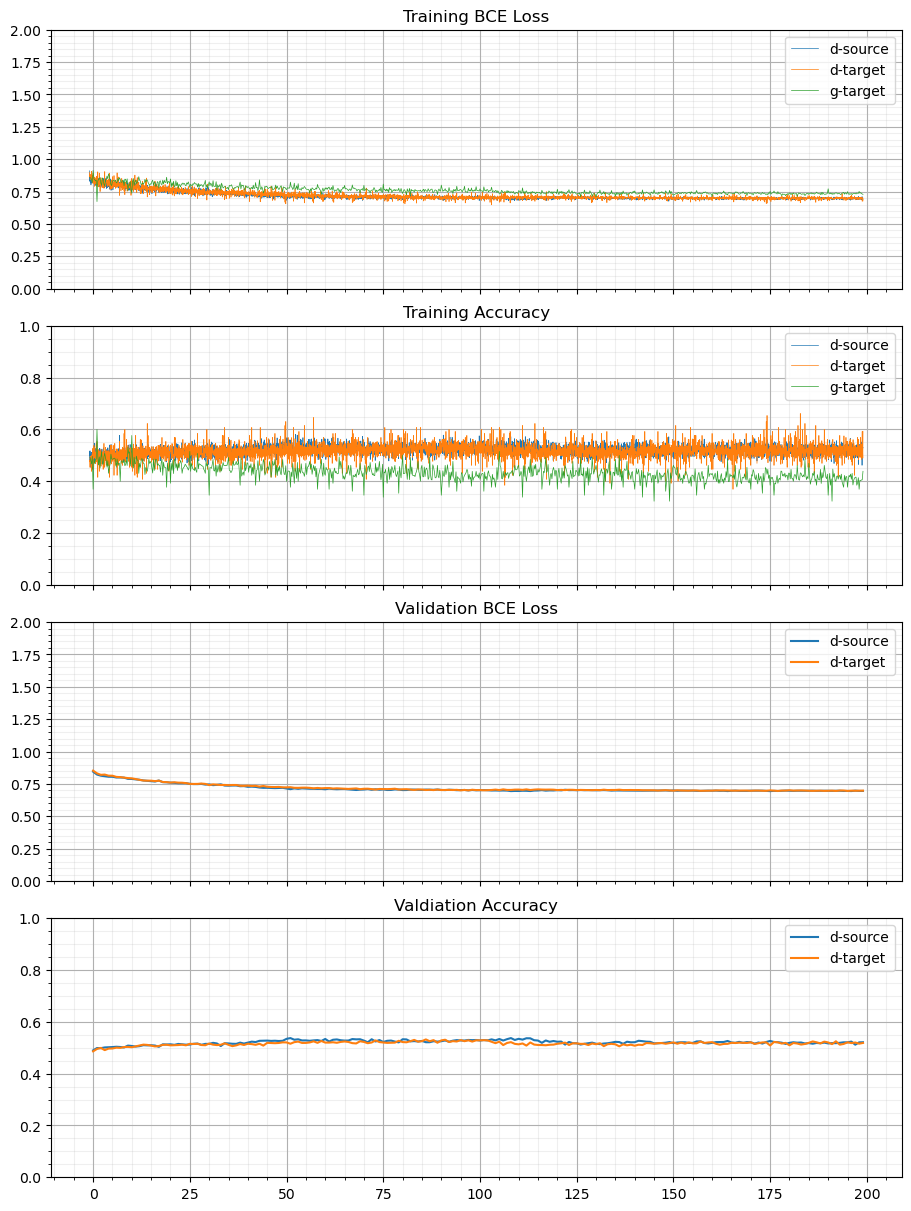

Adversarial training for ST slide 151508: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.8216 - 0.4998 ||| 0.8191 - 0.8693 | 0.5084 - 0.4734 || 0.7063 - 0.6910 | 0.4688 - 0.5328 
     1 ||| 0.8333 - 0.4836 ||| 0.8185 - 0.8264 | 0.4984 - 0.4927 || 0.6965 - 0.7219 | 0.5116 - 0.5018 
     2 ||| 0.8297 - 0.4811 ||| 0.8104 - 0.8208 | 0.4992 - 0.4917 || 0.7100 - 0.7345 | 0.4504 - 0.4642 
     3 ||| 0.8357 - 0.4849 ||| 0.8027 - 0.8126 | 0.5035 - 0.4983 || 0.6947 - 0.7253 | 0.5148 - 0.4544 
     4 ||| 0.8222 - 0.4877 ||| 0.8014 - 0.8107 | 0.5059 - 0.4957 || 0.6841 - 0.7287 | 0.5536 - 0.4528 
     5 ||| 0.8306 - 0.4742 ||| 0.8050 - 0.8031 | 0.5016 -

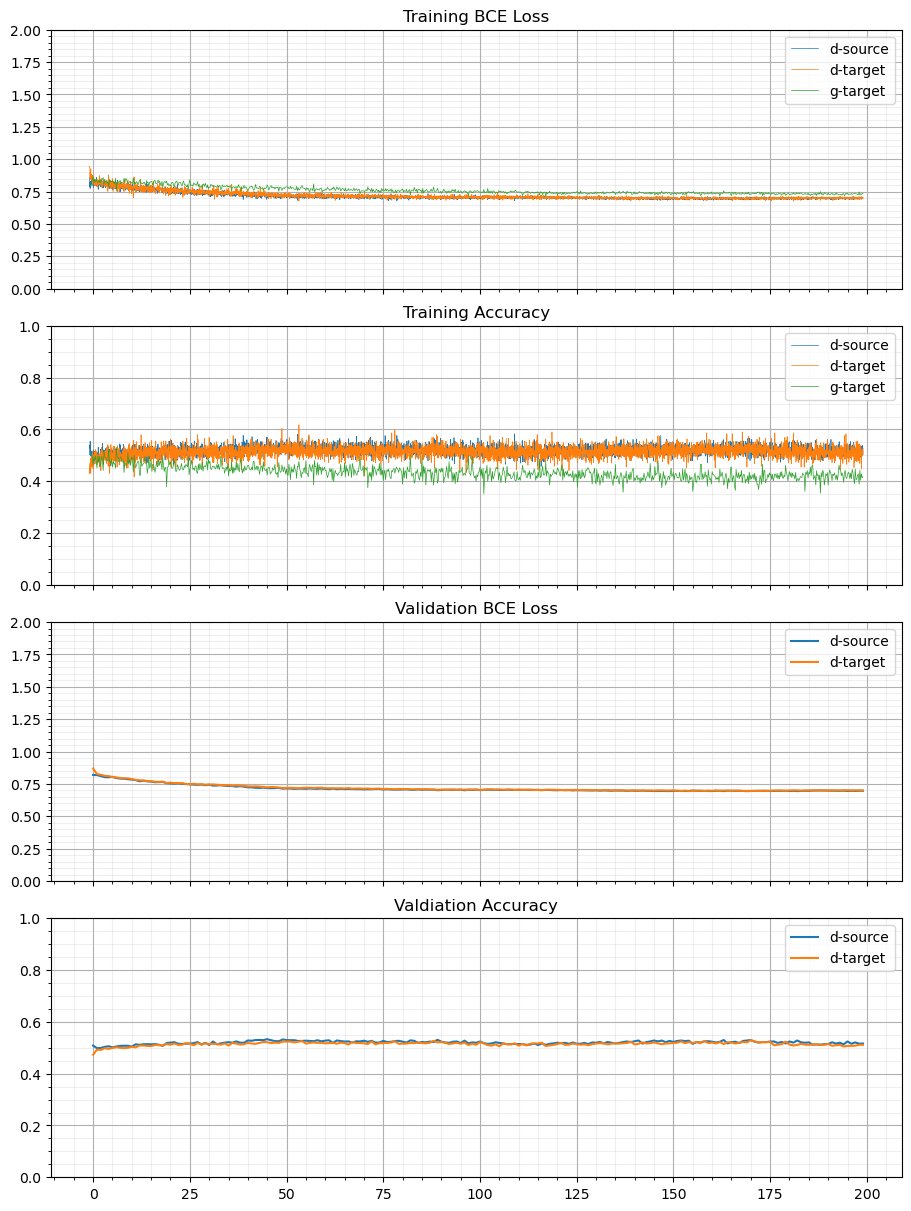

Adversarial training for ST slide 151509: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7952 - 0.5258 ||| 0.7717 - 0.9209 | 0.5453 - 0.4431 || 0.6660 - 0.7492 | 0.6212 - 0.4172 
     1 ||| 0.8493 - 0.4746 ||| 0.8183 - 0.8313 | 0.5052 - 0.4890 || 0.6662 - 0.7608 | 0.6272 - 0.4375 
     2 ||| 0.8333 - 0.4947 ||| 0.8043 - 0.8180 | 0.5093 - 0.5005 || 0.6425 - 0.7634 | 0.7096 - 0.3972 
     3 ||| 0.8499 - 0.4684 ||| 0.8028 - 0.8141 | 0.5061 - 0.4956 || 0.6577 - 0.7547 | 0.6544 - 0.4274 
     4 ||| 0.8304 - 0.4886 ||| 0.8052 - 0.8153 | 0.5044 - 0.4969 || 0.6321 - 0.7597 | 0.7432 - 0.3694 
     5 ||| 0.8340 - 0.4784 ||| 0.7946 - 0.8066 | 0.5108 -

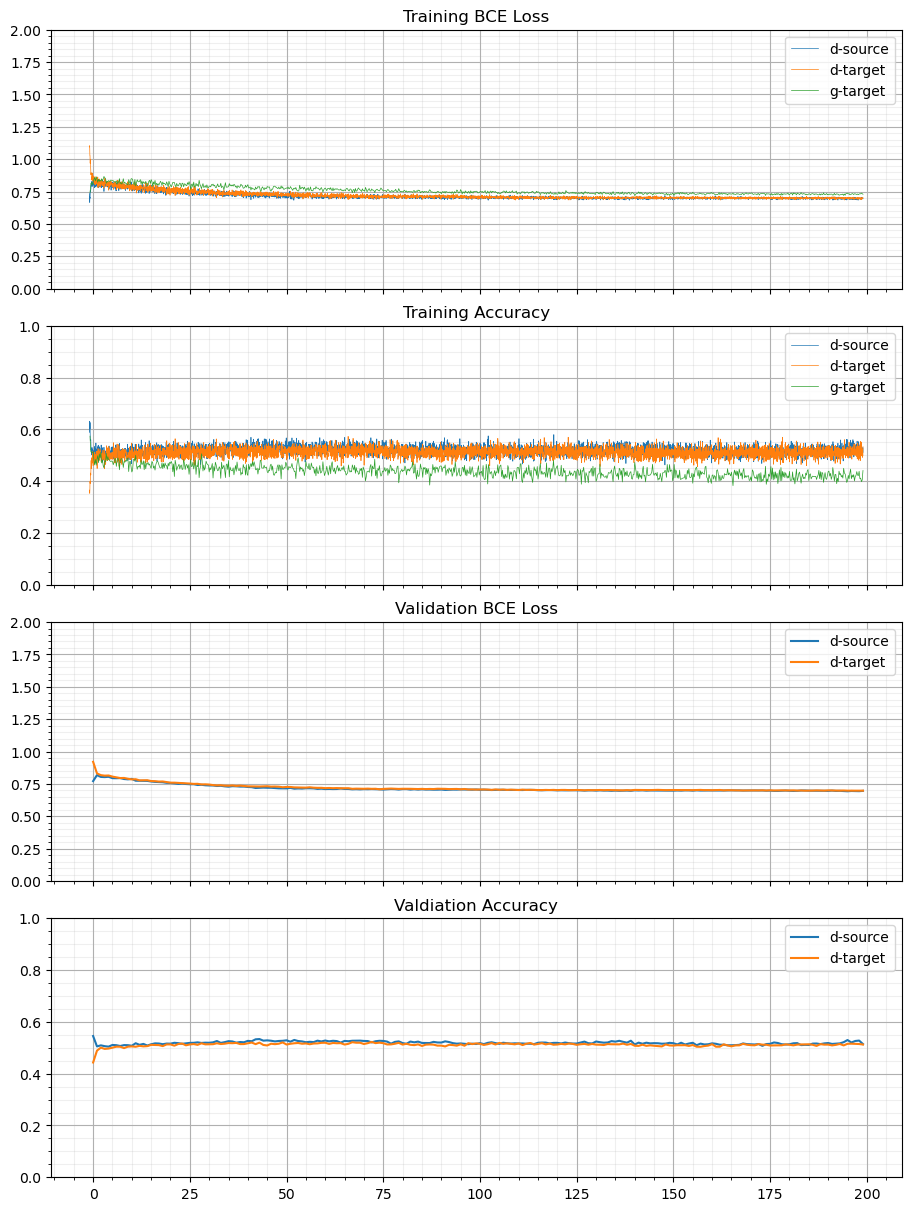

Adversarial training for ST slide 151510: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7934 - 0.5272 ||| 0.7679 - 0.9374 | 0.5504 - 0.4343 || 0.7123 - 0.6993 | 0.4560 - 0.5404 
     1 ||| 0.8435 - 0.4765 ||| 0.8203 - 0.8305 | 0.5016 - 0.4933 || 0.6642 - 0.7400 | 0.6144 - 0.4486 
     2 ||| 0.8389 - 0.4823 ||| 0.8144 - 0.8252 | 0.5028 - 0.4937 || 0.6724 - 0.7414 | 0.5908 - 0.4502 
     3 ||| 0.8347 - 0.4862 ||| 0.8122 - 0.8192 | 0.5023 - 0.4969 || 0.6725 - 0.7392 | 0.5968 - 0.4471 
     4 ||| 0.8430 - 0.4776 ||| 0.8066 - 0.8145 | 0.5014 - 0.5016 || 0.6789 - 0.7181 | 0.5600 - 0.5110 
     5 ||| 0.8249 - 0.4866 ||| 0.8010 - 0.8077 | 0.5062 -

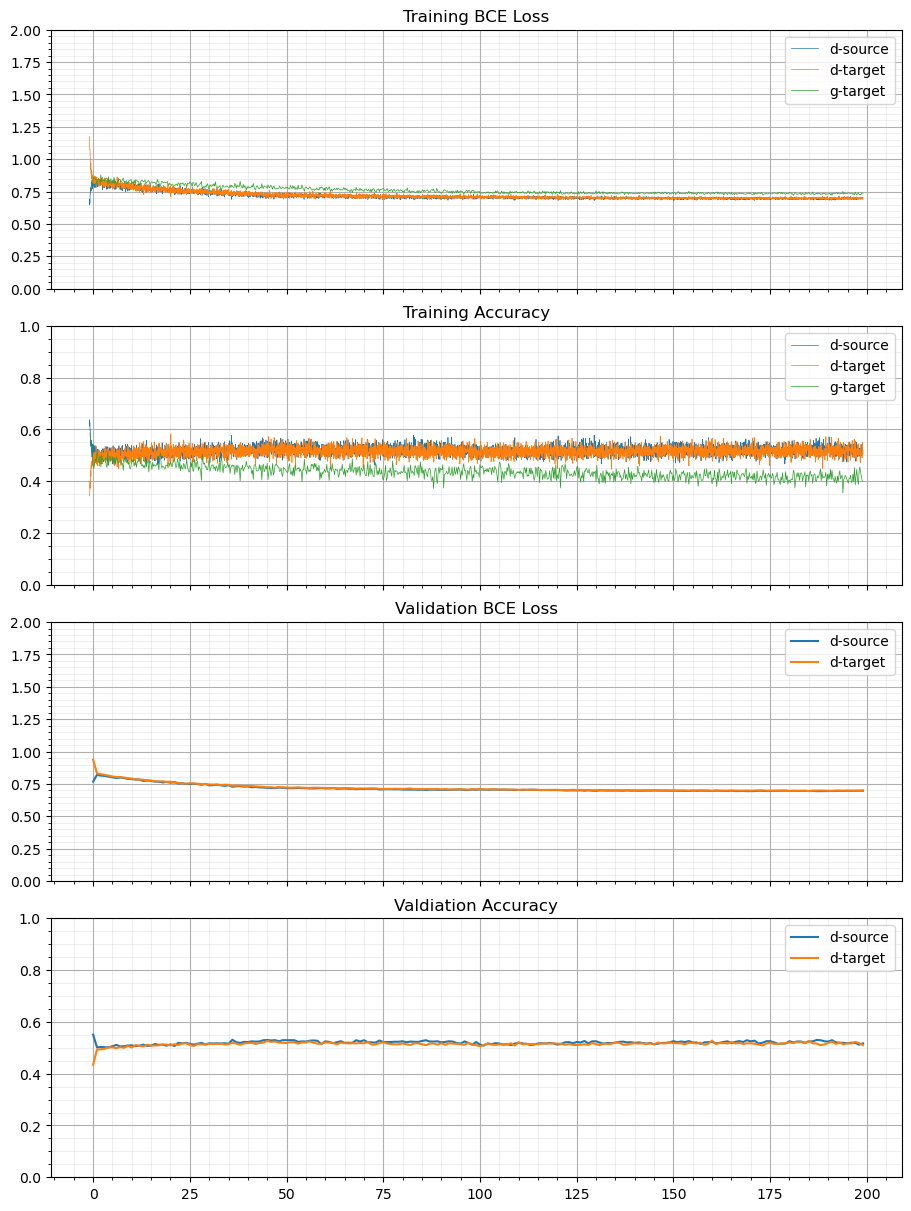

Adversarial training for ST slide 151669: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.9077 - 0.4466 ||| 0.9332 - 0.7693 | 0.4400 - 0.5507 || 0.6930 - 0.7412 | 0.5252 - 0.4745 
     1 ||| 0.8367 - 0.4835 ||| 0.8180 - 0.8244 | 0.5048 - 0.5003 || 0.6567 - 0.7781 | 0.6320 - 0.4010 
     2 ||| 0.8303 - 0.4799 ||| 0.8039 - 0.8166 | 0.5145 - 0.4999 || 0.6417 - 0.7887 | 0.6652 - 0.3846 
     3 ||| 0.8438 - 0.4685 ||| 0.7934 - 0.8146 | 0.5212 - 0.4994 || 0.6407 - 0.7743 | 0.6664 - 0.4231 
     4 ||| 0.8356 - 0.4810 ||| 0.8008 - 0.8139 | 0.5138 - 0.5005 || 0.6404 - 0.7695 | 0.6844 - 0.4155 
     5 ||| 0.8397 - 0.4674 ||| 0.7993 - 0.8048 | 0.5125 -

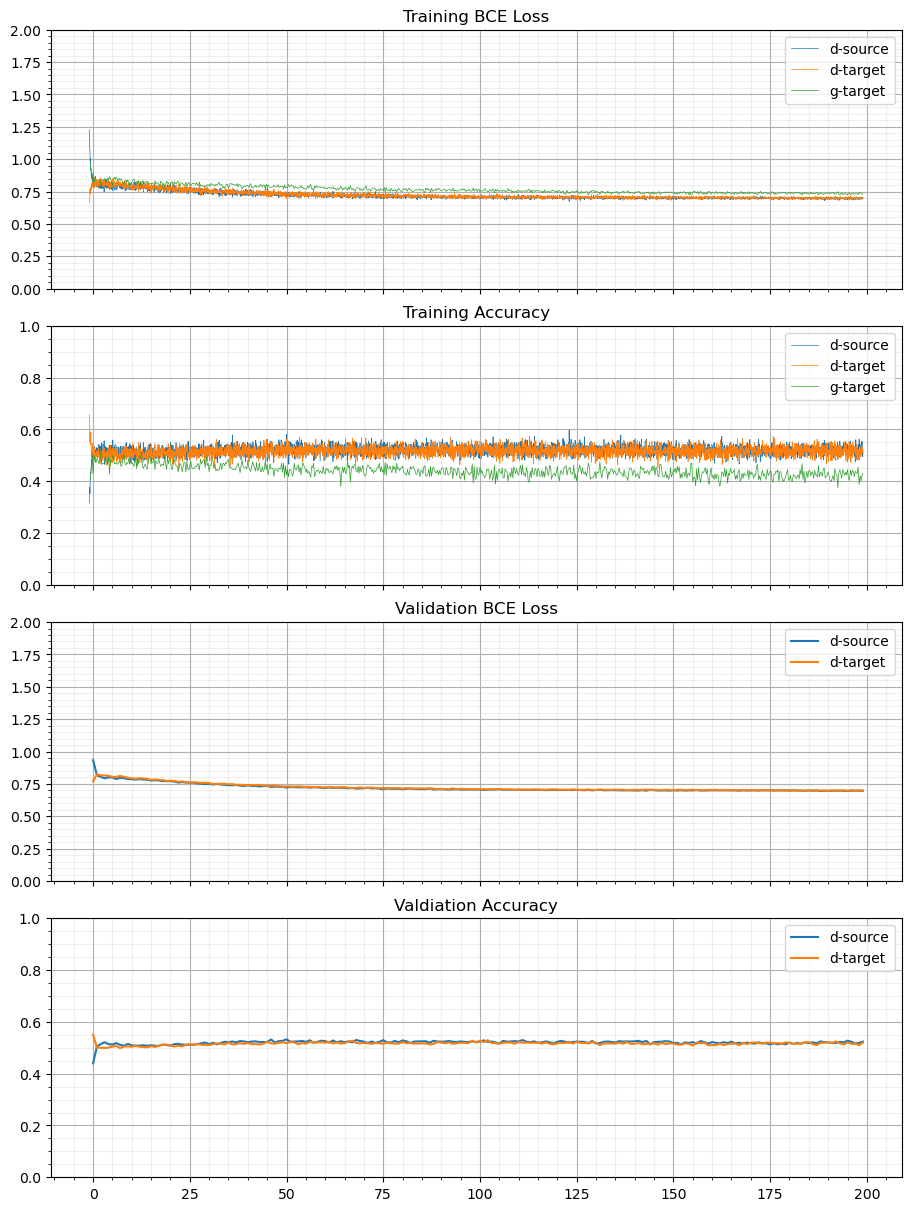

Adversarial training for ST slide 151670: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7714 - 0.5432 ||| 0.7614 - 0.9445 | 0.5565 - 0.4320 || 0.6828 - 0.7418 | 0.5632 - 0.4380 
     1 ||| 0.8512 - 0.4771 ||| 0.8198 - 0.8323 | 0.5040 - 0.4907 || 0.6909 - 0.7367 | 0.5324 - 0.4728 
     2 ||| 0.8312 - 0.4974 ||| 0.8152 - 0.8230 | 0.5000 - 0.5006 || 0.6536 - 0.7428 | 0.6552 - 0.4448 
     3 ||| 0.8279 - 0.4926 ||| 0.8052 - 0.8179 | 0.5145 - 0.5010 || 0.6741 - 0.7605 | 0.5832 - 0.4525 
     4 ||| 0.8464 - 0.4660 ||| 0.8051 - 0.8167 | 0.5090 - 0.5017 || 0.6319 - 0.7566 | 0.7148 - 0.4014 
     5 ||| 0.8481 - 0.4688 ||| 0.8022 - 0.8107 | 0.5069 -

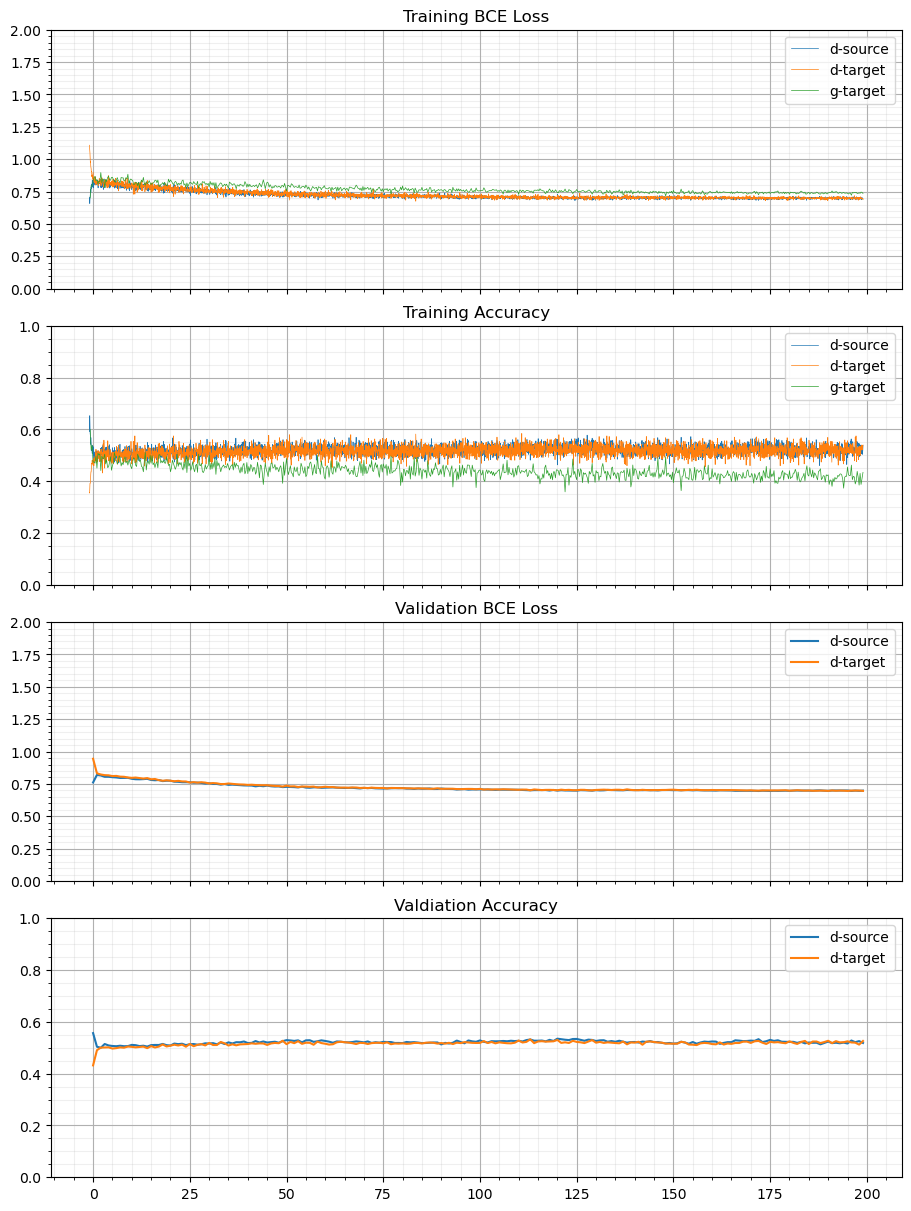

Adversarial training for ST slide 151671: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7574 - 0.5557 ||| 0.7142 - 0.9951 | 0.5890 - 0.4090 || 0.6768 - 0.8511 | 0.5760 - 0.4012 
     1 ||| 0.8609 - 0.4757 ||| 0.8196 - 0.8215 | 0.5049 - 0.5103 || 0.6352 - 0.8723 | 0.6960 - 0.3854 
     2 ||| 0.8386 - 0.4737 ||| 0.8053 - 0.8151 | 0.5156 - 0.5107 || 0.8041 - 0.8136 | 0.2824 - 0.5302 
     3 ||| 0.8502 - 0.4669 ||| 0.8042 - 0.7996 | 0.5110 - 0.5201 || 0.7056 - 0.6701 | 0.5116 - 0.6153 
     4 ||| 0.8478 - 0.4752 ||| 0.7989 - 0.8109 | 0.5130 - 0.5102 || 0.6999 - 0.8854 | 0.4988 - 0.4932 
     5 ||| 0.8500 - 0.4633 ||| 0.8074 - 0.8022 | 0.5017 -

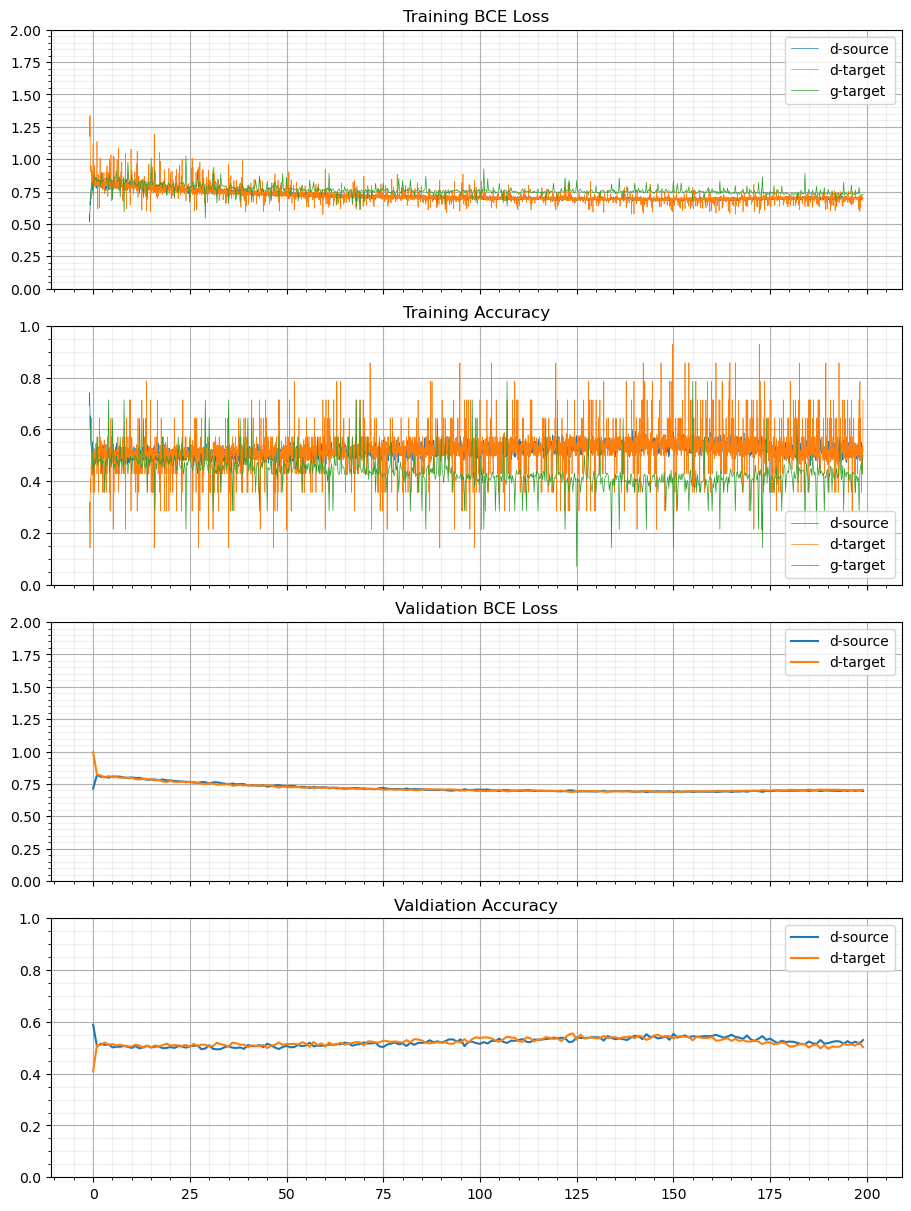

Adversarial training for ST slide 151672: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7705 - 0.5370 ||| 0.7052 - 0.9578 | 0.5941 - 0.4154 || 0.6877 - 0.7791 | 0.5156 - 0.4625 
     1 ||| 0.8458 - 0.4800 ||| 0.7853 - 0.8157 | 0.5338 - 0.5054 || 0.6955 - 0.8050 | 0.4960 - 0.4560 
     2 ||| 0.8439 - 0.4770 ||| 0.7843 - 0.8130 | 0.5241 - 0.4967 || 0.6648 - 0.8028 | 0.5696 - 0.4237 
     3 ||| 0.8458 - 0.4595 ||| 0.7938 - 0.8125 | 0.5173 - 0.5055 || 0.6495 - 0.8026 | 0.6368 - 0.4062 
     4 ||| 0.8395 - 0.4667 ||| 0.7976 - 0.8149 | 0.5132 - 0.4996 || 0.6209 - 0.8042 | 0.7280 - 0.3776 
     5 ||| 0.8294 - 0.4780 ||| 0.7879 - 0.8025 | 0.5171 -

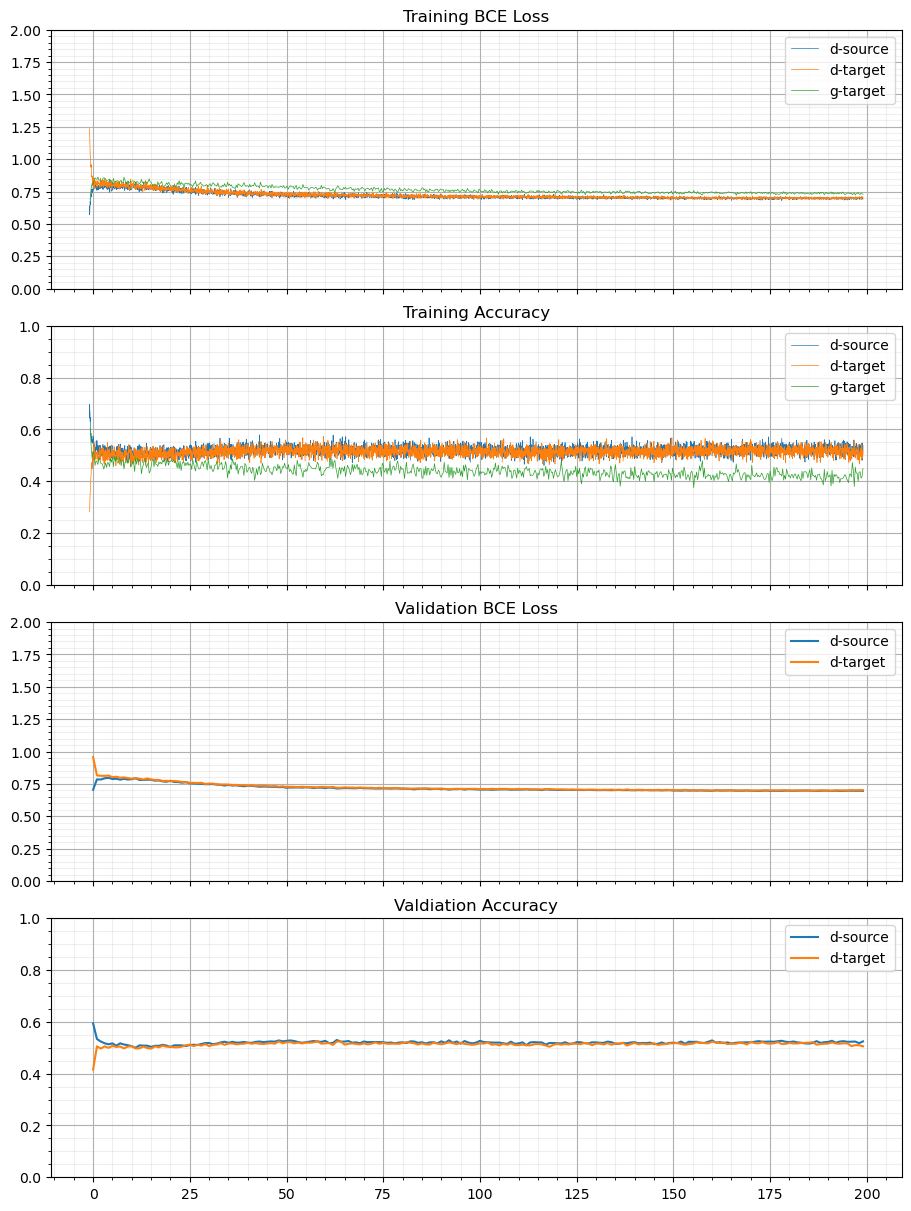

Adversarial training for ST slide 151673: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7740 - 0.5405 ||| 0.7548 - 0.9330 | 0.5549 - 0.4306 || 0.6797 - 0.7093 | 0.5772 - 0.4957 
     1 ||| 0.8312 - 0.4845 ||| 0.8116 - 0.8288 | 0.5083 - 0.4950 || 0.6832 - 0.7127 | 0.5596 - 0.5213 
     2 ||| 0.8492 - 0.4713 ||| 0.8063 - 0.8143 | 0.5116 - 0.5003 || 0.6543 - 0.7420 | 0.6416 - 0.4619 
     3 ||| 0.8493 - 0.4644 ||| 0.8046 - 0.8203 | 0.5052 - 0.4956 || 0.6577 - 0.7290 | 0.6320 - 0.5048 
     4 ||| 0.8462 - 0.4608 ||| 0.8019 - 0.8084 | 0.5128 - 0.5054 || 0.6688 - 0.7130 | 0.6068 - 0.5414 
     5 ||| 0.8434 - 0.4584 ||| 0.7956 - 0.8105 | 0.5102 -

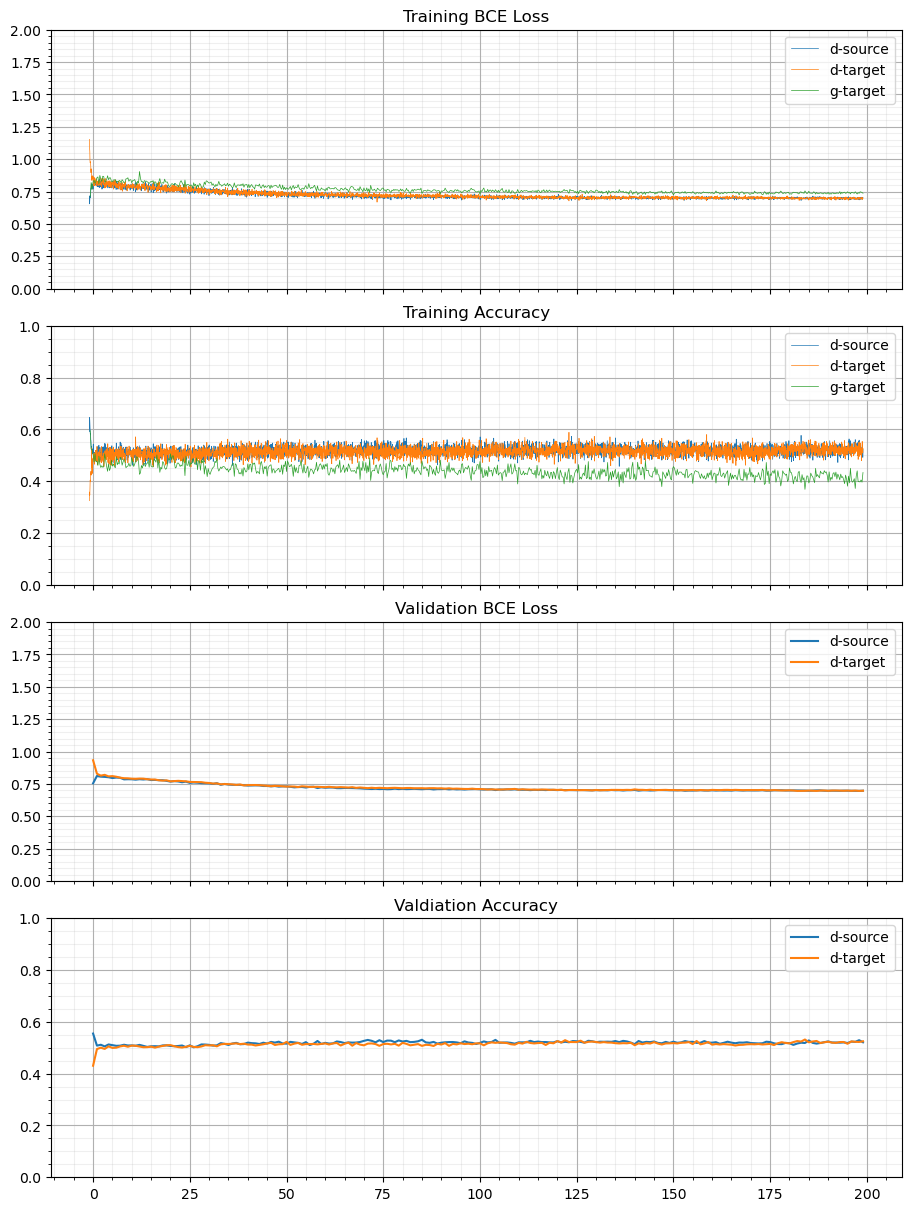

Adversarial training for ST slide 151674: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7928 - 0.5265 ||| 0.7447 - 0.9512 | 0.5723 - 0.4234 || 0.6575 - 0.7412 | 0.6620 - 0.3809 
     1 ||| 0.8243 - 0.4843 ||| 0.8121 - 0.8308 | 0.5062 - 0.4883 || 0.6799 - 0.7420 | 0.5700 - 0.4277 
     2 ||| 0.8369 - 0.4811 ||| 0.8071 - 0.8246 | 0.5094 - 0.4876 || 0.6894 - 0.7268 | 0.5424 - 0.5050 
     3 ||| 0.8346 - 0.4800 ||| 0.8058 - 0.8168 | 0.5063 - 0.4956 || 0.6609 - 0.7308 | 0.6436 - 0.4566 
     4 ||| 0.8496 - 0.4607 ||| 0.8028 - 0.8122 | 0.5049 - 0.4982 || 0.6573 - 0.7295 | 0.6528 - 0.4563 
     5 ||| 0.8403 - 0.4715 ||| 0.8050 - 0.8060 | 0.4992 -

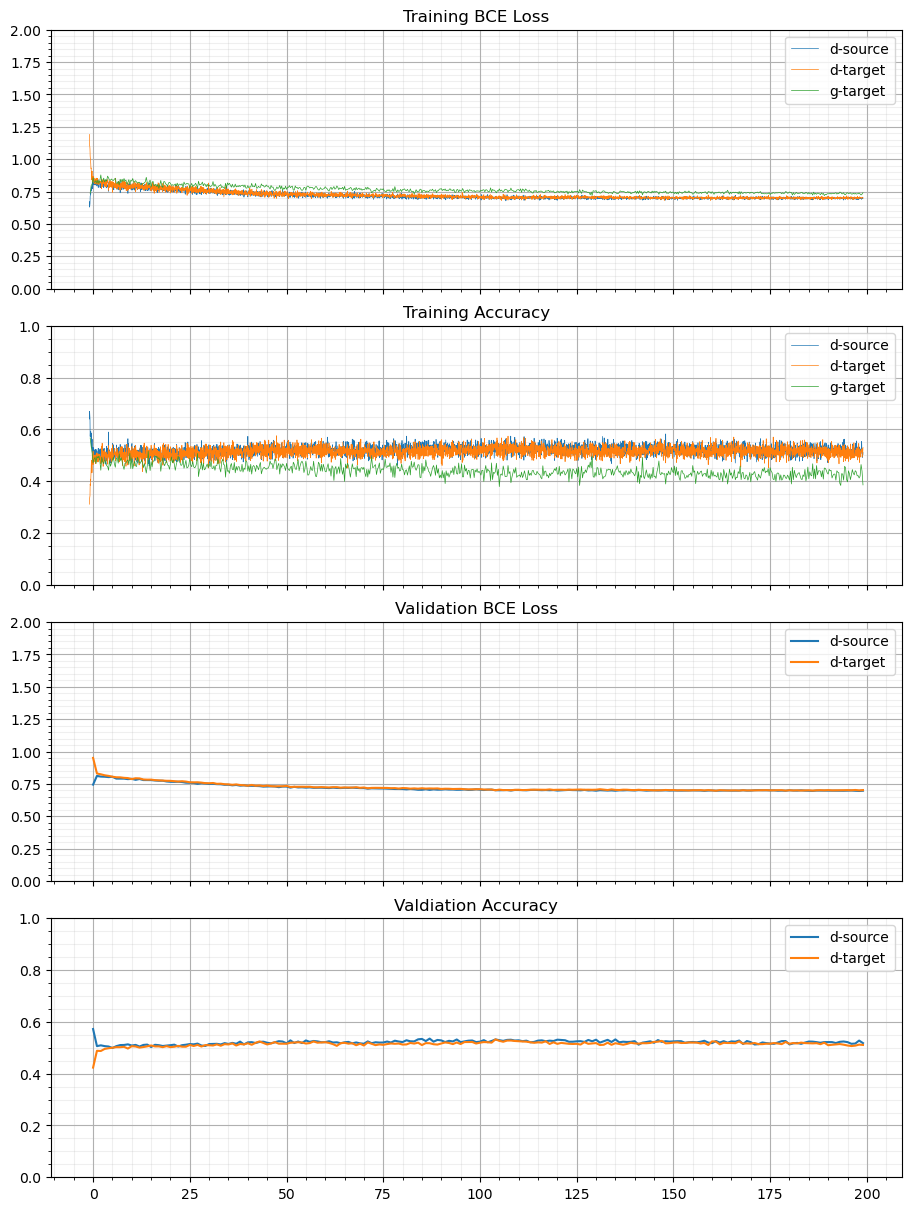

Adversarial training for ST slide 151675: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.8324 - 0.5042 ||| 0.8426 - 0.8494 | 0.5011 - 0.4895 || 0.6655 - 0.7426 | 0.6264 - 0.4145 
     1 ||| 0.8355 - 0.4900 ||| 0.8211 - 0.8330 | 0.4984 - 0.4899 || 0.6675 - 0.7489 | 0.6156 - 0.4262 
     2 ||| 0.8499 - 0.4694 ||| 0.8122 - 0.8263 | 0.5042 - 0.4914 || 0.6683 - 0.7528 | 0.6072 - 0.4268 
     3 ||| 0.8321 - 0.4864 ||| 0.8050 - 0.8192 | 0.5070 - 0.5028 || 0.6560 - 0.7516 | 0.6576 - 0.4246 
     4 ||| 0.8264 - 0.4825 ||| 0.8077 - 0.8180 | 0.5062 - 0.4977 || 0.6603 - 0.7266 | 0.6496 - 0.4788 
     5 ||| 0.8374 - 0.4713 ||| 0.8033 - 0.8070 | 0.5100 -

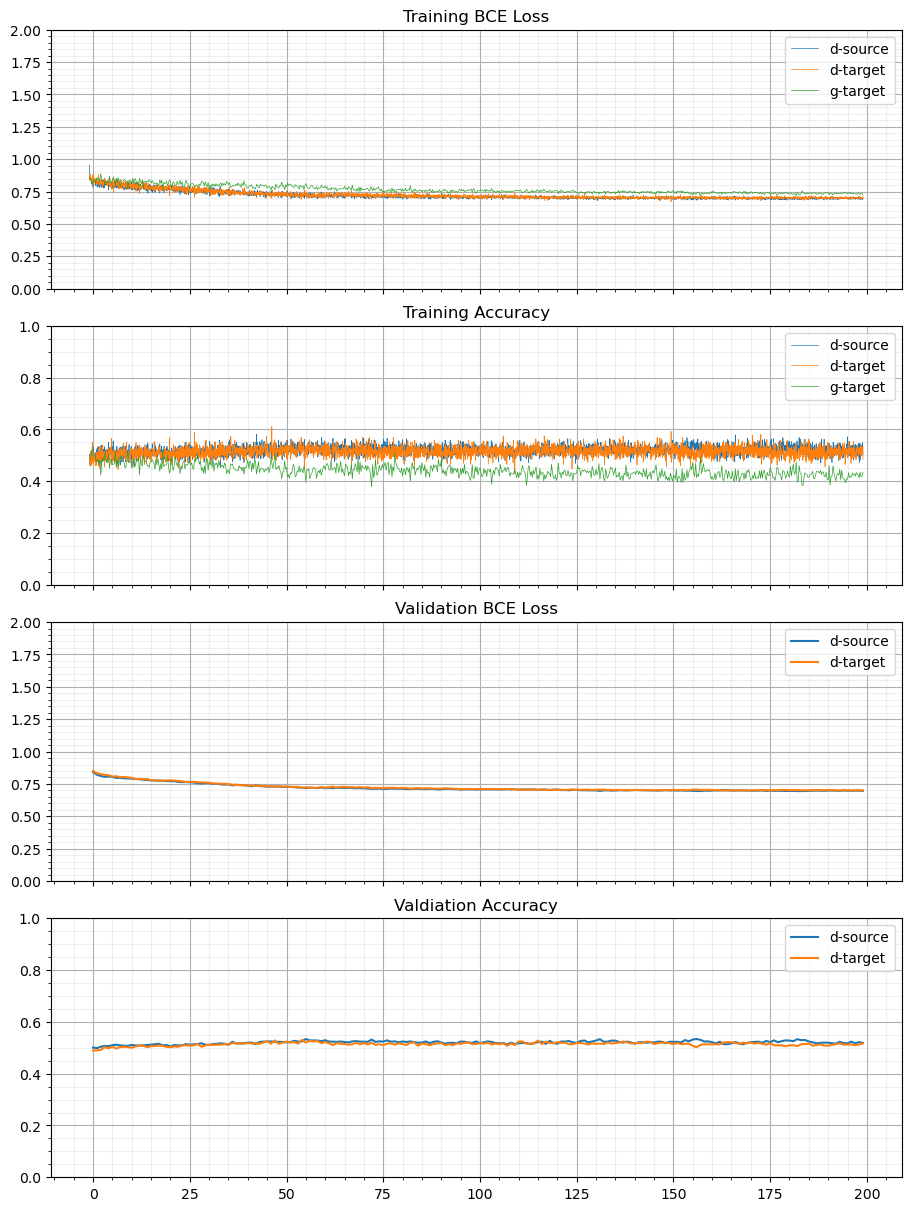

Adversarial training for ST slide 151676: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Generator       ||| Discriminator 
       ||| Train           ||| Train                             || Validation    
       ||| Loss   | Accu   ||| Loss            | Accu            || Loss            | Accu  
       ||| Target - Target ||| Source - Target | Source - Target || Source - Target | Source - Target 
------------------------------------------------------------------------------------------------------
     0 ||| 0.7354 - 0.5702 ||| 0.6891 - 1.0431 | 0.6121 - 0.3744 || 0.6908 - 0.7009 | 0.5364 - 0.5101 
     1 ||| 0.8473 - 0.4832 ||| 0.8209 - 0.8425 | 0.5021 - 0.4844 || 0.7133 - 0.6989 | 0.4420 - 0.5422 
     2 ||| 0.8286 - 0.4882 ||| 0.8139 - 0.8248 | 0.5034 - 0.4947 || 0.7170 - 0.6865 | 0.4188 - 0.6023 
     3 ||| 0.8552 - 0.4731 ||| 0.8167 - 0.8241 | 0.4941 - 0.4917 || 0.7090 - 0.6895 | 0.4756 - 0.5928 
     4 ||| 0.8284 - 0.4798 ||| 0.8115 - 0.8166 | 0.5022 - 0.4966 || 0.7025 - 0.6943 | 0.4920 - 0.5962 
     5 ||| 0.8340 - 0.4896 ||| 0.8063 - 0.8148 | 0.5034 -

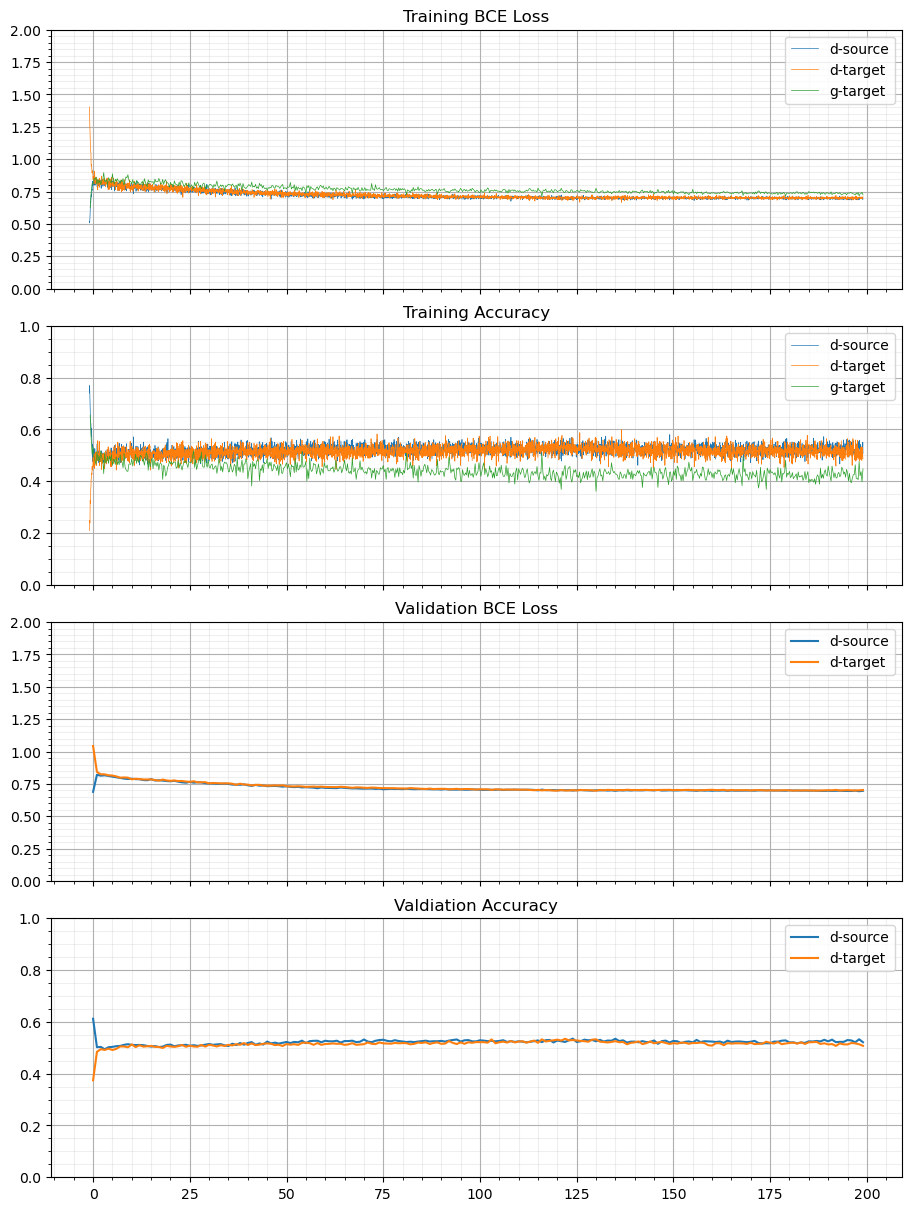

In [23]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = ADDAST(
        sc_mix_d["train"].shape[1],
        ncls_source=lab_mix_d["train"].shape[1],
        is_adda=True,
        **adda_kwargs,
    )

    model.source_encoder.load_state_dict(
        best_checkpoint["model"].source_encoder.state_dict()
    )
    model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())

    model.init_adv()
    model.dis.apply(initialize_weights)
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
        dataloader_target_train_dis,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

        model = ADDAST(
            sc_mix_d["train"].shape[1],
            ncls_source=lab_mix_d["train"].shape[1],
            is_adda=True,
            **adda_kwargs,
        )

        model.apply(initialize_weights)

        # load state dicts
        # this makes it easier, if, say, the discriminator changes
        model.source_encoder.load_state_dict(
            best_checkpoint["model"].source_encoder.state_dict()
        )

        model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())

        model.init_adv()
        model.dis.apply(initialize_weights)

        model.to(device)

        model.advtraining()

        results = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
            dataloader_target_train_dis_d[sample_id],
        )
        plot_results(*results, save_folder)

## Evaluation of latent space

In [24]:
# from sklearn.decomposition import PCA
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier


# for sample_id in st_sample_id_l:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#     )
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()

#     with torch.no_grad():
#         source_emb = model.source_encoder(torch.Tensor(sc_mix_train_s).to(device))
#         target_emb = model.target_encoder(
#             torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
#         )

#         y_dis = torch.cat(
#             [
#                 torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
#                 torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
#             ]
#         )

#         emb = torch.cat([source_emb, target_emb])

#         emb = emb.detach().cpu().numpy()
#         y_dis = y_dis.detach().cpu().numpy()

#     (emb_train, emb_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
#         emb,
#         y_dis,
#         test_size=0.2,
#         random_state=225,
#         stratify=y_dis,
#     )

#     pca = PCA(n_components=50)
#     pca.fit(emb_train)

#     emb_train_50 = pca.transform(emb_train)
#     emb_test_50 = pca.transform(emb_test)

#     clf = RandomForestClassifier(random_state=145, n_jobs=-1)
#     clf.fit(emb_train_50, y_dis_train)
#     accu_train = clf.score(emb_train_50, y_dis_train)
#     accu_test = clf.score(emb_test_50, y_dis_test)
#     class_proportions = np.mean(y_dis)

#     print(
#         "Training accuracy: {}, Test accuracy: {}, Class proportions: {}".format(
#             accu_train, accu_test, class_proportions
#         )
#     )


 # 4. Predict cell fraction of spots and visualization

In [25]:
# pred_sp_d, pred_sp_noda_d = {}, {}
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()
#     with torch.no_grad():
#         for sample_id in st_sample_id_l:
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )

# else:
#     for sample_id in st_sample_id_l:
#         best_checkpoint = torch.load(
#             os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#         )
#         model = best_checkpoint["model"]
#         model.to(device)

#         model.eval()
#         model.target_inference()

#         with torch.no_grad():
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )


# best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     for sample_id in st_sample_id_l:
#         pred_sp_noda_d[sample_id] = (
#             torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
#             .detach()
#             .cpu()
#             .numpy()
#         )


In [26]:
# adata_spatialLIBD = sc.read_h5ad(
#     os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
# )

# adata_spatialLIBD_d = {}
# for sample_id in st_sample_id_l:
#     adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ]
#     adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
#         adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
#     )


In [27]:
# num_name_exN_l = []
# for k, v in sc_sub_dict.items():
#     if "Ex" in v:
#         num_name_exN_l.append((k, v, int(v.split("_")[1])))
# num_name_exN_l.sort(key=lambda a: a[2])
# num_name_exN_l


In [28]:
# Ex_to_L_d = {
#     1: {5, 6},
#     2: {5},
#     3: {4, 5},
#     4: {6},
#     5: {5},
#     6: {4, 5, 6},
#     7: {4, 5, 6},
#     8: {5, 6},
#     9: {5, 6},
#     10: {2, 3, 4},
# }


In [29]:
# numlist = [t[0] for t in num_name_exN_l]
# Ex_l = [t[2] for t in num_name_exN_l]
# num_to_ex_d = dict(zip(numlist, Ex_l))


In [30]:
# def plot_cellfraction(visnum, adata, pred_sp, ax=None):
#     """Plot predicted cell fraction for a given visnum"""
#     adata.obs["Pred_label"] = pred_sp[:, visnum]
#     # vmin = 0
#     # vmax = np.amax(pred_sp)

#     sc.pl.spatial(
#         adata,
#         img_key="hires",
#         color="Pred_label",
#         palette="Set1",
#         size=1.5,
#         legend_loc=None,
#         title=f"{sc_sub_dict[visnum]}",
#         spot_size=100,
#         show=False,
#         # vmin=vmin,
#         # vmax=vmax,
#         ax=ax,
#     )


In [31]:
# def plot_roc(visnum, adata, pred_sp, name, ax=None):
#     """Plot ROC for a given visnum"""

#     def layer_to_layer_number(x):
#         for char in x:
#             if char.isdigit():
#                 if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
#                     return 1
#         return 0

#     y_pred = pred_sp[:, visnum]
#     y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
#     # print(y_true)
#     # print(y_true.isna().sum())
#     RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


In [32]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

# sc.pl.spatial(
#     adata_spatialLIBD_d[SAMPLE_ID_N],
#     img_key=None,
#     color="spatialLIBD",
#     palette="Accent_r",
#     size=1.5,
#     title=SAMPLE_ID_N,
#     # legend_loc = 4,
#     spot_size=100,
#     show=False,
#     ax=ax,
# )

# ax.axis("equal")
# ax.set_xlabel("")
# ax.set_ylabel("")

# fig.show()


In [33]:
# fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

# for i, num in enumerate(numlist):
#     plot_cellfraction(
#         num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
#     )
#     ax.flat[i].axis("equal")
#     ax.flat[i].set_xlabel("")
#     ax.flat[i].set_ylabel("")

# fig.show()

# fig, ax = plt.subplots(
#     2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
# )

# for i, num in enumerate(numlist):
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_d[SAMPLE_ID_N],
#         "ADDA",
#         ax.flat[i],
#     )
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_noda_d[SAMPLE_ID_N],
#         "NN_wo_da",
#         ax.flat[i],
#     )
#     ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     ax.flat[i].set_title(f"{sc_sub_dict[num]}")

#     if i >= len(numlist) - 5:
#         ax.flat[i].set_xlabel("FPR")
#     else:
#         ax.flat[i].set_xlabel("")
#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("TPR")
#     else:
#         ax.flat[i].set_ylabel("")

# fig.show()


In [34]:
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
# else:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
#     )

# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     pred_mix = (
#         torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
#         .detach()
#         .cpu()
#         .numpy()
#     )

# cell_type_nums = sc_sub_dict.keys()
# nrows = ceil(len(cell_type_nums) / 5)

# line_kws = {"color": "tab:orange"}
# scatter_kws = {"s": 5}

# props = dict(facecolor="w", alpha=0.5)

# fig, ax = plt.subplots(
#     nrows,
#     5,
#     figsize=(25, 5 * nrows),
#     constrained_layout=True,
#     sharex=False,
#     sharey=True,
# )
# for i, visnum in enumerate(cell_type_nums):
#     sns.regplot(
#         x=pred_mix[:, visnum],
#         y=lab_mix_test[:, visnum],
#         line_kws=line_kws,
#         scatter_kws=scatter_kws,
#         ax=ax.flat[i],
#     ).set_title(sc_sub_dict[visnum])

#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlabel("Predicted Proportion")

#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("True Proportion")
#     else:
#         ax.flat[i].set_ylabel("")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     textstr = (
#         f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
#     )

#     # place a text box in upper left in axes coords
#     ax.flat[i].text(
#         0.95,
#         0.05,
#         textstr,
#         transform=ax.flat[i].transAxes,
#         verticalalignment="bottom",
#         horizontalalignment="right",
#         bbox=props,
#     )

# for i in range(len(cell_type_nums), nrows * 5):
#     ax.flat[i].axis("off")

# plt.show()
